In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from reproject.healpix import reproject_to_healpix

import os
print (os.getcwd())
print (os.listdir())

from astropy.io import fits


/home/cbllover/HalfDome
['halfdome_y100_halo_mass_hist_for_kSZ_m1e12.png', 'y_tSZ_nside4096_sigmoid.fits', 'cosmology.py', 'y_100.fits:Zone.Identifier', 'kappa_zs0.5_s100.fits:Zone.Identifier', 'halfdome_y100_halo_mass_hist_for_kSZ_m1e13.png', '.git', 'Comparison_between_HalfDome_and_websky_M13_cut_all3.png', 'kappa_zs0.5_s100.fits', 'kSZ_HalfDome_y100_big.png', 'hist.png', 'halfdome_y100_halo_mass_hist_for_kSZ_13Msol_cutoff.png', 'y_tSZ_13Msol_cutoff.fits', 'kSZ_HalfDome_y100_healpix_big.png', 'Comparison_between_HalfDome_and_websky_full.png', 'Websky_tests.ipynb', 'halfdome_y100_halo_mass_hist_for_kSZ_total_sigmoid.png', 'Halfdome_analysis-checkpoint.ipynb', 'ksz_websky.fits:Zone.Identifier', 'globusconnectpersonal-latest.tgz', 'cached2_model_sigmoid_Ntheta512_pad256_integral_reduced_acc.jld2', 'kSZ_HalfDome_y100_13Msol_cutoff_FIELD.png', 'kSZ_HalfDome_y100_m1e13_sigmoid.png', 'y_100.fits', 'y_tSZ_nside4096_sigmoid_m1e13_corr_units_increased_acc.fits', 'y_tSZ_total_sigmoid.fits', 'ha

# tSZ maps

In [73]:
fname = "y_100.fits"
with fits.open(fname, memmap=True) as hdul:
    print("Number of HDUs:", len(hdul))
    print(hdul.info())

Number of HDUs: 1
Filename: y_100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (43200, 21601)   float64   
None


In [80]:
fname = "y_100.fits"
hdu = fits.open(fname, memmap=True)[0]
hdr = hdu.header

# Detect frame from header (GLON/GLAT → galactic; otherwise fallback to ICRS)
ctype1 = (hdr.get('CTYPE1','') or '').upper()
coord_system = 'galactic' if 'GLON' in ctype1 else 'icrs'

NSIDE = 1024  
y_map, footprint = reproject_to_healpix((hdu.data, hdr),
                                        coord_system,
                                        nside=NSIDE, 
                                       nested = False)  # 'ring' indexing

y_map = y_map.astype('f4', copy=False)

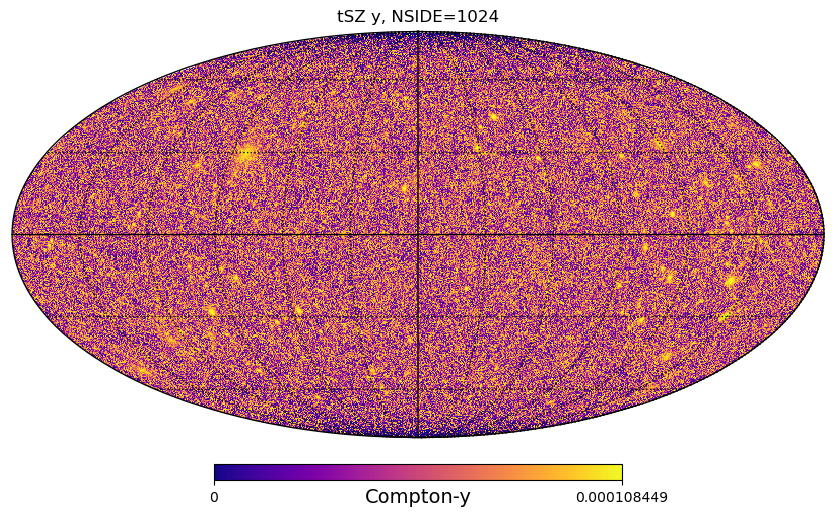

In [81]:
hp.mollview(y_map, title=f"tSZ y, NSIDE={NSIDE}",
            unit="Compton-y", norm="hist", cmap = "plasma")
hp.graticule()
plt.show()

In [13]:
lmax = 3*hp.get_nside(y_map) - 1
cl = hp.anafast(y_map, lmax=lmax)
ell = np.arange(len(cl))




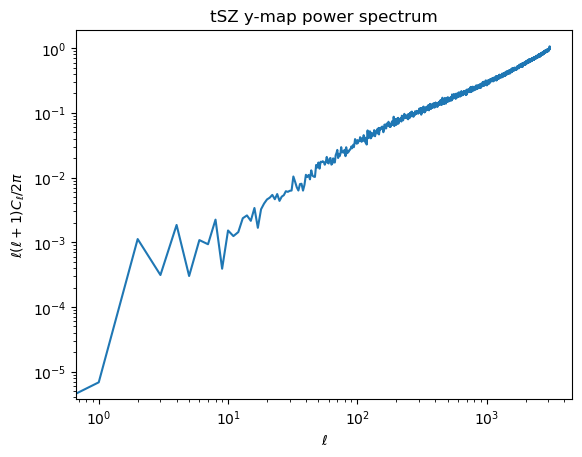

In [14]:
Dl = ell*(ell+1)*cl/(2*np.pi)*10**12
#Dl = cl/(2*np.pi)*10**12
plt.loglog(ell, Dl)
plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi$")
plt.title("tSZ y-map power spectrum")
plt.show()

# Lensing map

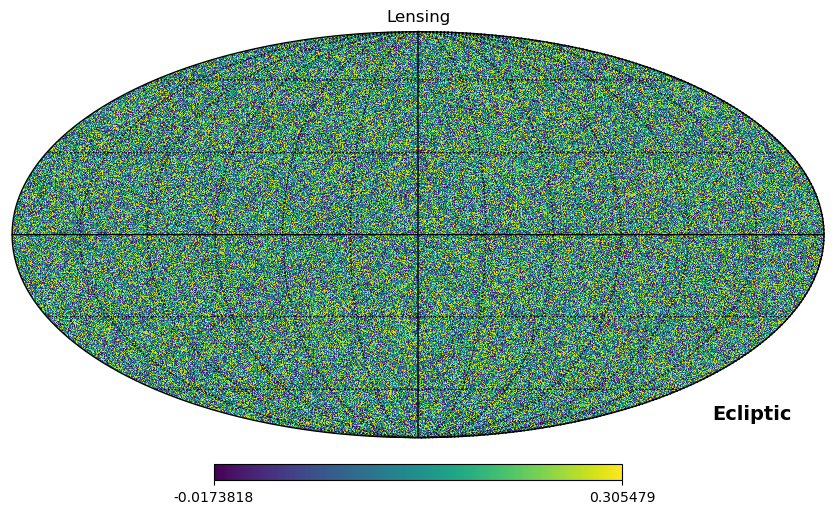

In [7]:
fname = "kappa_zs0.5_s100.fits"             # lensing

# Read as float32 with memory mapping; load only field 0
lensing_map = hp.read_map(fname)

hp.mollview(lensing_map, coord=['G','E'], title='Lensing', norm='hist', xsize=2000)
hp.graticule()

# Lightcone

In [67]:
fname = "lightcone_100.hdf5"   # adjust filename
NSIDE = 1024                                 
zmin, zmax = 0.0, 1.0
Mmin = 1e09                                 

# allocate map
npix = hp.nside2npix(NSIDE)
map_counts = np.zeros(npix, dtype=np.float32)
map_mass = np.zeros(npix, dtype=np.float32)

with h5py.File(fname, "r") as f:
    pos  = f["Position"]      # [N,3] Cartesian positions (unit sphere, radians)
    z    = f["redshift"]
    m200 = f["halo_mass_m200c"]

    N = pos.shape[0]
    print(f"Total halos: {N:,}")

    chunk = int(1e08)
    for i in range(0, N, chunk):
        p  = pos[i:i+chunk][...]
        zz = z[i:i+chunk][...]
        mm = m200[i:i+chunk][...]

        # convert Cartesian → spherical
        x, y, zc = p[:,0], p[:,1], p[:,2]


        sel = np.isfinite(x) & np.isfinite(y) & np.isfinite(zc) & (zz >= zmin) & (zz < zmax) & (mm >= Mmin)
        if not np.any(sel):
           continue

        ipix  = hp.vec2pix(NSIDE, x[sel], y[sel], zc[sel], nest=False)
        np.add.at(map_counts, ipix, 1.0)

        # fast accumulate using bincount
        bins = np.bincount(ipix, weights=mm[sel], minlength=npix).astype(np.float32)
        map_mass += bins
        # mass-weighted
        np.add.at(map_mass, ipix, mm[sel])


Total halos: 85,224,251


In [68]:
print(np.corrcoef(map_counts, map_mass)[0,1])  # should be < 1


0.605986099122364


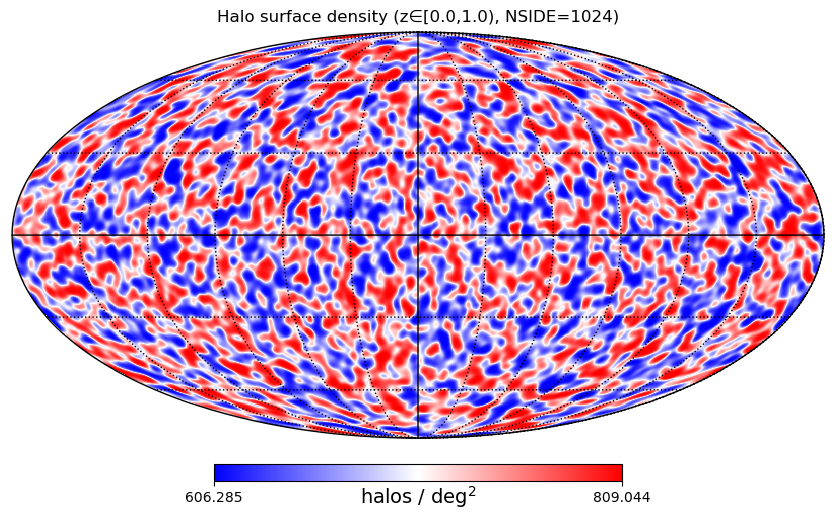

In [69]:
# convert to per-deg²
pix_area_sr = 4*np.pi / map_counts.size
deg2_per_pix = pix_area_sr * (180/np.pi)**2
map_per_deg2 = map_counts / deg2_per_pix
map_per_deg2_smoothed = hp.smoothing(map_per_deg2, fwhm=np.radians(3.))


hp.mollview(map_per_deg2_smoothed, title=f"Halo surface density (z∈[{zmin},{zmax}), NSIDE={NSIDE})",
            unit="halos / deg$^2$", norm="hist", cmap="bwr")
hp.graticule()
plt.show()

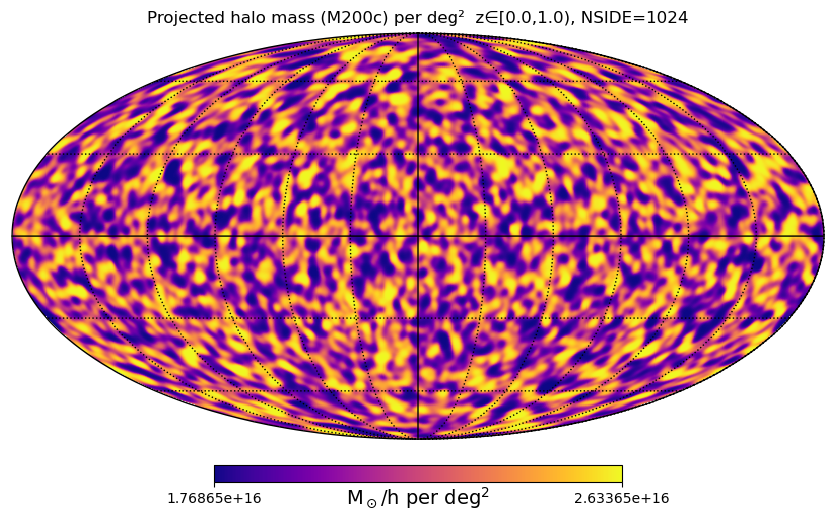

In [70]:
# convert to mass per deg^2 (nice colorbar)
pix_area_sr   = 4*np.pi / npix
deg2_per_pix  = pix_area_sr * (180/np.pi)**2
map_mass_deg2 = map_mass / deg2_per_pix
map_mass_deg2_smoothed = hp.smoothing(map_mass_deg2, fwhm=np.radians(3.))

hp.mollview(map_mass_deg2_smoothed,
            title=f"Projected halo mass (M200c) per deg²  z∈[{zmin},{zmax}), NSIDE={NSIDE}",
            unit="M$_\\odot$/h per deg$^2$",
            norm="hist",
            cmap="plasma")
hp.graticule()
plt.show()

In [19]:
lmax = 3*hp.get_nside(map_per_deg2) - 1
cl = hp.anafast(map_per_deg2, lmax=lmax)
ell = np.arange(len(cl))

Dl = ell*(ell+1)*cl/(2*np.pi)
#Dl = cl/(2*np.pi)*10**12
plt.loglog(ell, Dl)
plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi$")
plt.title("Halo density power spectrum")
plt.show()

NameError: name 'map_per_deg2' is not defined

# Julia/xgpaint results

In [3]:
def plot_kSZ(fname, title = "kSZ map TOTAL (NSIDE=2048)", unit = r"ΔT, $(\mu K)$", cmap = "plasma", scale = 1):
    # The tSZ Compton-y map (field 0)
    y_map = hp.read_map(fname, field=0, nest=False, dtype=np.float32)
    
    # Plot it directly
    hp.mollview(y_map*scale, title=title, unit=unit, norm="hist", cmap = cmap, format="%.1e")
    hp.graticule()
    plt.show()
    return y_map

In [4]:
def power_spectra_computation(fname):
    data_full = hp.read_map(fname, field=0, nest=False, dtype=np.float32)

    lmax = 3*hp.get_nside(data_full) - 1
    cl = hp.anafast(data_full, lmax=lmax)
    ell = np.arange(len(cl))
    Dl = ell*(ell+1)*cl/(2*np.pi)
    return Dl, ell

In [5]:
def plot_power_spectra(y_map, title = "Power spectrum of total kSZ map"):
    lmax = 3*hp.get_nside(y_map) - 1
    cl = hp.anafast(y_map, lmax=lmax)
    ell = np.arange(len(cl))

    Dl = ell*(ell+1)*cl/(2*np.pi)*10**12
    #Dl = cl/(2*np.pi)*10**12
    plt.loglog(ell, Dl*10**6)
    plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi, (\mu K^2)$")
    plt.xlim((70, 6000))
    plt.title(title)
    plt.show()
    return Dl

# Seperating between halo and fields

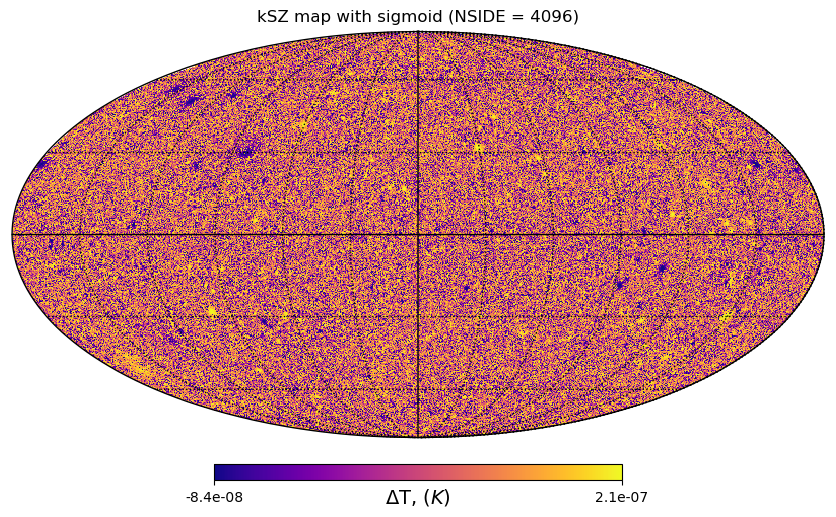

In [6]:
# The 1- halo code

fname = "y_tSZ_total_sigmoid.fits"
halo_kSZ_map = plot_kSZ(fname, title  = r"kSZ map with sigmoid (NSIDE = 4096)", unit = r"ΔT, $(K)$")

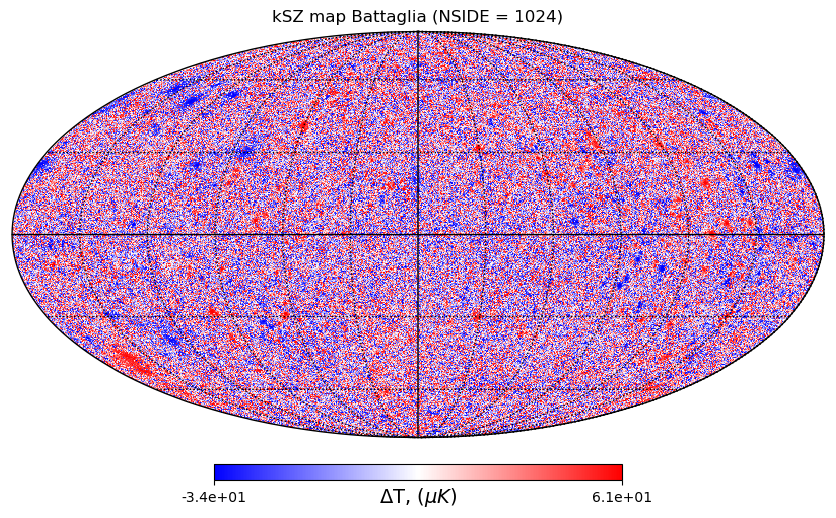

In [38]:

# The 1- halo code

fname = "y_tSZ_small_regular_interpolated.fits"
halo_kSZ_map = plot_kSZ(fname, title  = r"kSZ map Battaglia (NSIDE = 1024)", unit = r"ΔT, $(\mu K)$", cmap = "bwr", scale = 10**6)

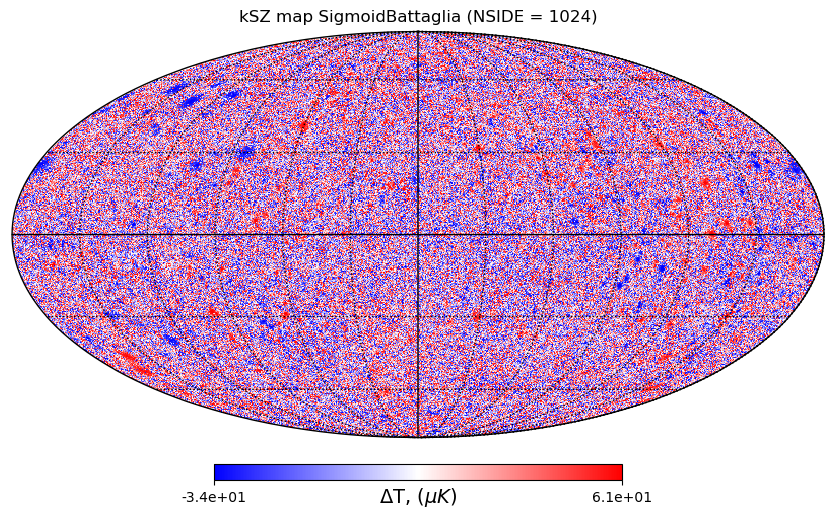

In [23]:

# The 1- halo code

fname = "y_tSZ_small_sigmoid.fits"
halo_kSZ_map = 2.7255*10**(-3)*plot_kSZ(fname, title  = r"kSZ map SigmoidBattaglia (NSIDE = 1024)", unit = r"ΔT, $(\mu K)$", cmap = "bwr", scale = 10**6)

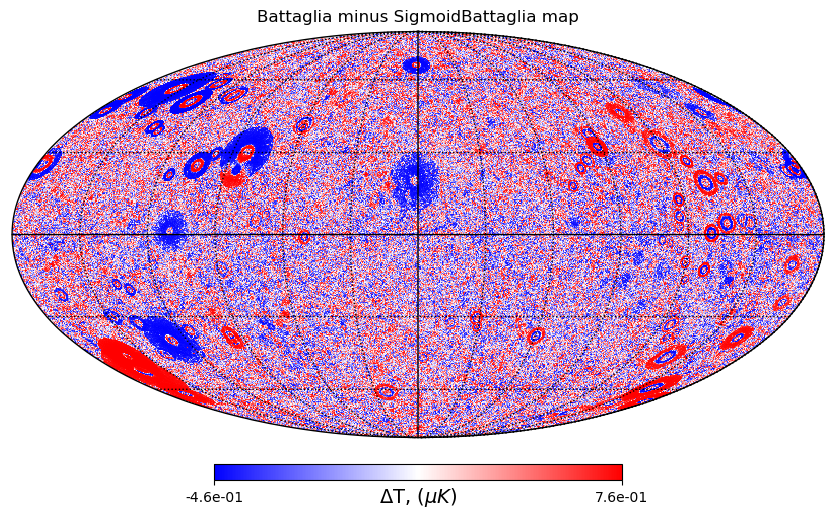

In [54]:
title = "Battaglia minus SigmoidBattaglia map"
unit = r"ΔT, $(\mu K)$"
cmap = "bwr"

fname1 = "y_tSZ_small_sigmoid.fits"
fname2 = "y_tSZ_small_regular_interpolated.fits"

y_map1 = hp.read_map(fname1, field=0, nest=False, dtype=np.float32)
y_map2 = hp.read_map(fname2, field=0, nest=False, dtype=np.float32)

# Plot it directly
hp.mollview((y_map2 - y_map1)*10**6, title=title, unit=unit, norm="hist", cmap = cmap, format="%.1e")
hp.graticule()
plt.show()

In [29]:
np.multiply(y_map1, 2.7255*10**(-3)) == 2.7255*10**(-3)*y_map1

array([ True,  True,  True, ...,  True,  True,  True])

In [19]:
lmax1 = 3*hp.get_nside(y_map1) - 1
cl1 = hp.anafast(y_map1, lmax=lmax1)
ell1 = np.arange(len(cl1))

lmax2 = 3*hp.get_nside(y_map2) - 1
cl2 = hp.anafast(y_map2, lmax=lmax2)
ell2 = np.arange(len(cl2))

Dl1 = ell1*(ell1+1)*cl1/(2*np.pi)*10**12
Dl2 = ell2*(ell2+1)*cl2/(2*np.pi)*10**12
#Dl = cl/(2*np.pi)*10**12


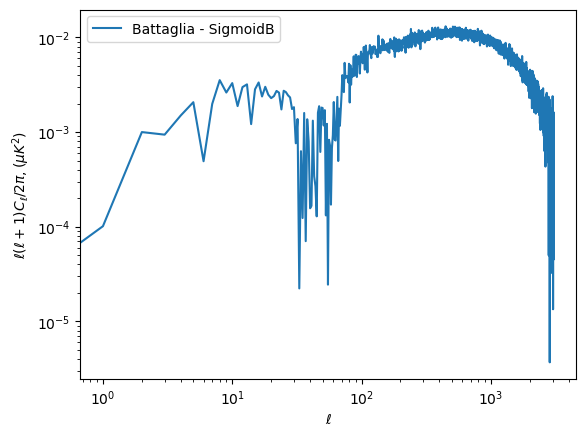

In [47]:
plt.loglog(ell1, abs(Dl1 - Dl2), label = "Battaglia - SigmoidB")
# plt.loglog(ell2, Dl2, "-.", label = "SigmoidBattaglia")


plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi, (\mu K^2)$")
# plt.xlim((70, 6000))
# plt.title(title)
plt.legend()
plt.show()

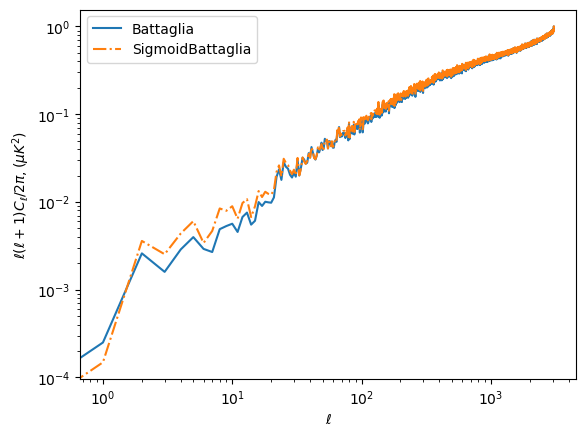

In [49]:
plt.loglog(ell1, Dl1, label = "Battaglia")
plt.loglog(ell2, Dl2, "-.", label = "SigmoidBattaglia")


plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi, (\mu K^2)$")
# plt.xlim((70, 6000))
# plt.title(title)
plt.legend()
plt.show()

# WEB-sky comparison

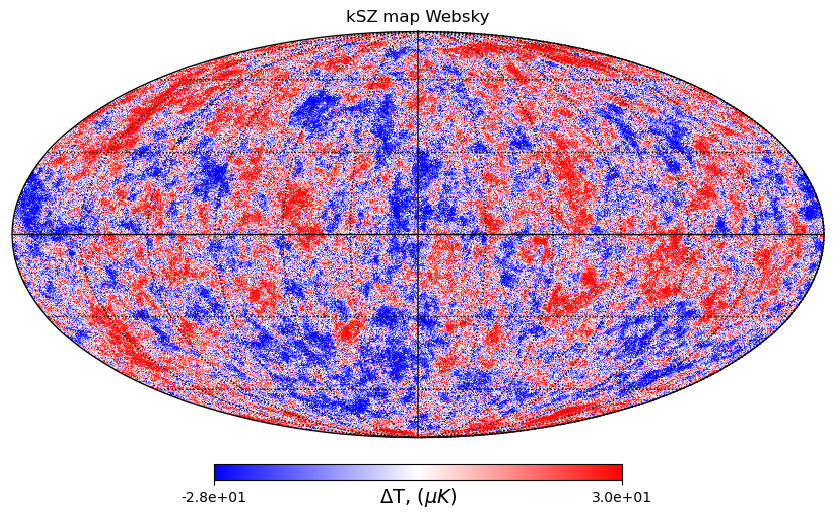

In [4]:

fname = "ksz_websky.fits"
websky_full = plot_kSZ(fname, title  = r"kSZ map Websky", unit = r"ΔT, $(\mu K)$", cmap = "bwr")

In [6]:
fname1 = "y_tSZ_nside4096_sigmoid.fits"

fname = "ksz_websky.fits"
Dl1, ell1 = power_spectra_computation(fname)


# Dl2, ell2 = power_spectra_computation(fname1)

In [6]:
fname2 = "y_tSZ_small_sigmoid.fits"
Dl3, ell3 = power_spectra_computation(fname2)

In [7]:
fname3 = "y_tSZ_nside4096_sigmoid_m1e13_corr_units.fits"


Dl4, ell4 = power_spectra_computation(fname3)

In [9]:
fname4 = "y_tSZ_nside4096_sigmoid_m1e13.fits"

Dl5, ell5 = power_spectra_computation(fname4)

In [7]:
fname5 = "y_tSZ_nside4096_sigmoid_m1e13_corr_units_increased_acc.fits"

Dl6, ell6 = power_spectra_computation(fname5)

In [16]:
fname6 = "y_tSZ_nside1024_sigmoid_m1e13_corr_units_increased_acc.fits"
Dl7, ell7 = power_spectra_computation(fname6)

In [8]:
fname7= "y_tSZ_nside4096_sigmoid_13Msol_cutoff_HALO _m200m.fits"
Dl8, ell8 = power_spectra_computation(fname7)

In [16]:

fname9= "other_sims/148_ksz_healpix_nopell_Nside4096_DeltaT_uK.fits"
Dl9, ell9 = power_spectra_computation(fname9)

In [22]:
fname10 = "other_sim_Tcmb_tSZ_nside4096_sigmoid_13Msol_cutoff_HALO_m200m.fits"
Dl10, ell10 = power_spectra_computation(fname10)

In [30]:
import astropy.io.fits as fits
fits.info(fname7)


Filename: kSZ_Box0_35x35_MAGNETICUM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (6144, 6144)   float32   


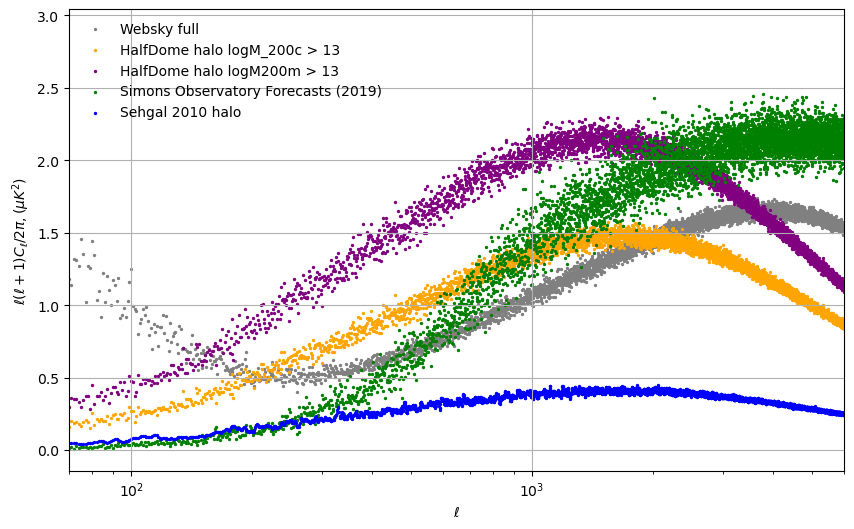

In [29]:
plt.figure(figsize = (10, 6))
factor_mult = (2.7255*1e6)**2
CMB_factor = 1/(2.73**2)
plt.scatter(ell1, Dl1, s = 2, label = "Websky full", c= 'grey')
# plt.scatter(ell2, Dl2*factor_mult, s = 2, label = "HalfDome")
# plt.scatter(ell3, Dl3, s=2, label = "HalfDome nside = 1024")
# plt.scatter(ell4, Dl4*factor_mult, s = 2, label = "HalfDome M>1e13 corrected", c = "orange")
# plt..scatter(ell5, Dl5*factor_mult, s = 2, label = "HalfDome M>1e13", c= "red")
plt.scatter(ell6, Dl6*factor_mult, s = 2, label = "HalfDome halo logM_200c > 13", c = "orange")
plt.scatter(ell8, Dl8*factor_mult, s = 2, label = "HalfDome halo logM200m > 13", c = "purple")
plt.scatter(ell9, Dl9, s = 2, label = "Simons Observatory Forecasts (2019)", c = "green")
plt.scatter(ell10, Dl10*factor_mult, s = 2, label = "Sehgal 2010 halo ", c = "blue")



plt.xlabel(r"$\ell$"); plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi, (\mu K^2)$")
plt.xlim((70, 6000))
plt.xscale("log")
# plt.title(title)
plt.legend(frameon = False)
plt.grid()
# plt.savefig("Comparison_between_HalfDome_and_websky_M13_cut.png")
plt.show()


### (Websky has m200m)

Data for other sims from https://lambda.gsfc.nasa.gov/simulation/full_sky_sims_ov.html

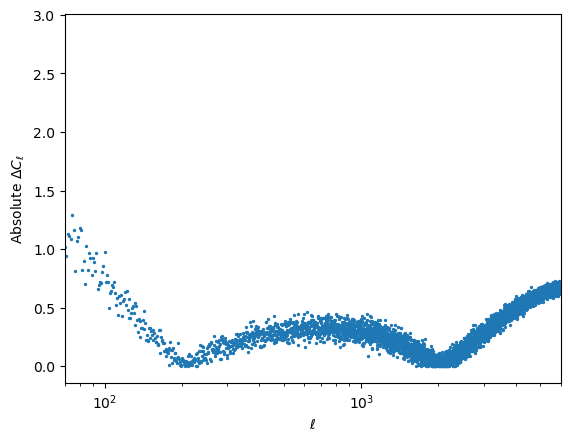

In [14]:
plt.scatter(ell4, abs((Dl4*factor_mult - Dl1)), s = 2, label = "HalfDome M>1e13")
plt.xlim((70, 6000))
plt.xlabel(r"$\ell$")
plt.ylabel(r"Absolute $\Delta C_{\ell}$")
plt.xscale("log")

## Cosmology
#### Websky:
(Ωm,Ωb,σ8,ns,h,τ) =(0.31,0.049,0.81,0.965,0.68,0.055)

Halo mass = 1.2 10^(12) M_sol(z < 4). Up to z = 4.6 it becomes 4e12 M_sol
#### Halfdome:
 h=0.6774, Ωm=0.3089, Ωb=0.0486, σ8=0.8159, ns=0.9667, Mν=0
 
 Halo Mass = 1.95 * 10^10 M_sol (in reality its around 5e12 M_sol from histograms of data)
 